In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
import shutil

In [2]:
image_dir = "/kaggle/input/c/opencode-24-geek-haven/train/train"

data = []

for file_name in os.listdir(image_dir):
    if file_name.lower().endswith((".jpg", ".png")):  
        file_path = os.path.join(image_dir, file_name)  
        label = os.path.splitext(file_name)[0]  
        data.append({"images": file_path, "labels": label})

df = pd.DataFrame(data)

df.to_csv("image_labels.csv", index=False)

print(f"Total images processed: {len(df)}")

Total images processed: 50000


In [3]:
data = pd.DataFrame(data)
data.head()

,images,labels
0,/kaggle/input/c/opencode-24-geek-haven/train/t...,zEUUR
1,/kaggle/input/c/opencode-24-geek-haven/train/t...,lhpJc
2,/kaggle/input/c/opencode-24-geek-haven/train/t...,yn9V9
3,/kaggle/input/c/opencode-24-geek-haven/train/t...,51cZ4
4,/kaggle/input/c/opencode-24-geek-haven/train/t...,FliTH


In [4]:
len(data)


50000

In [5]:
total_files = len(os.listdir(image_dir))
print(f"Total files in directory: {total_files}")

Total files in directory: 50000


# Fine tuning with learning rate scheduler

In [6]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import TrOCRProcessor, VisionEncoderDecoderModel, AdamW
from PIL import Image
import os
from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os


In [7]:
processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
model = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

preprocessor_config.json:   0%|          | 0.00/224 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:1601: FutureWarning: `clean_up_tokenization_spaces` was not set. It will be set to `True` by default. This behavior will be depracted in transformers v4.45, and will be then set to `False` by default. For more details check this issue: https://github.com/huggingface/transformers/issues/31884
  warnings.warn(


config.json:   0%|          | 0.00/4.17k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.33G [00:00<?, ?B/s]

Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


generation_config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [8]:
image = Image.open(data['images'][0])

inputs = processor(images=image, return_tensors="pt",)

print("Keys returned by the processor:", inputs.keys())

for key, value in inputs.items():
    print(f"{key}: {value.shape if isinstance(value, torch.Tensor) else value}")

Keys returned by the processor: dict_keys(['pixel_values'])
pixel_values: torch.Size([1, 3, 384, 384])


In [9]:
from transformers import TrOCRProcessor
import torch
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, image_paths, labels, processor):
        self.image_paths = image_paths
        self.labels = labels
        self.processor = processor

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = Image.open(self.image_paths[idx]).convert("RGB")

        inputs = self.processor(images=image, return_tensors="pt", padding=True)
        pixel_values = inputs['pixel_values'].squeeze(0)

        label = self.labels[idx]
        label_encoding = self.processor.tokenizer(label, padding="max_length", truncation=True, max_length=32, return_tensors="pt")
        labels_tensor = label_encoding.input_ids.squeeze(0)  # Convert to tensor

        return {"pixel_values": pixel_values, "labels": labels_tensor}


In [10]:
# import random

# image_paths = data['images']
# labels = data['labels']

# # Select a subset of 20k images
# subset_size = 1000
# subset_indices = random.sample(range(len(image_paths)), subset_size)
# image_paths_subset = [image_paths[i] for i in subset_indices]
# labels_subset = [labels[i] for i in subset_indices]

In [11]:
dataset = CustomDataset(data['images'], data['labels'], processor)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

# dataset = CustomDataset(image_paths_subset, labels_subset, processor)
# dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

In [12]:
batch = next(iter(dataloader))
batch

/usr/local/lib/python3.10/dist-packages/transformers/image_processing_utils.py:41: UserWarning: The following named arguments are not valid for `ViTImageProcessor.preprocess` and were ignored: 'padding'
  return self.preprocess(images, **kwargs)


{'pixel_values': tensor([[[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           ...,
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
           [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000]],
 
          [[-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059],
           [-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059],
           [-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059],
           ...,
           [-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059],
           [-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059],
           [-0.9059, -0.9059, -0.9059,  ..., -0.9059, -0.9059, -0.9059]],
 
          [[-0.6392, -0.6392, -0.6392,  ..., -0.6392, -0.6392, -0.6392

In [13]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id 
model.config.pad_token_id = processor.tokenizer.pad_token_id           

print("Decoder start token ID:", model.config.decoder_start_token_id)
print("Pad token ID:", model.config.pad_token_id)

Decoder start token ID: 0
Pad token ID: 1


In [14]:
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id or 0  
model.config.pad_token_id = processor.tokenizer.pad_token_id or 1           

print("Decoder start token ID:", model.config.decoder_start_token_id)
print("Pad token ID:", model.config.pad_token_id)

Decoder start token ID: 0
Pad token ID: 1


In [15]:
optimizer = AdamW(model.parameters(), lr=1e-5)

epochs = 8
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


VisionEncoderDecoderModel(
  (encoder): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=False)
              (key): Linear(in_features=768, out_features=768, bias=False)
              (value): Linear(in_features=768, out_features=768, bias=False)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_fea

In [16]:
for epoch in range(epochs):

    if epoch == 3:  
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr']*0.1
            print(param_group['lr'])

    if epoch == 5:  
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr']*0.1
            print(param_group['lr'])

    if epoch == 7:  
        for param_group in optimizer.param_groups:
            param_group['lr'] = param_group['lr']*0.1
            print(param_group['lr'])

    model.train()
    progress_bar = tqdm(dataloader, desc=f"Epoch {epoch + 1}/{epochs}")

    for batch in progress_bar:
        pixel_values = batch['pixel_values'].to(device)  
        labels = batch['labels'].to(device)  
        
        outputs = model(pixel_values=pixel_values, labels=labels)
        loss = outputs.loss

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        progress_bar.set_postfix(loss=loss.item())

    print(f"Epoch {epoch + 1} completed. Loss: {loss.item()}")

Epoch 1/8: 100%|██████████| 3125/3125 [1:17:50<00:00,  1.49s/it, loss=0.063]


Epoch 1 completed. Loss: 0.06297501921653748


Epoch 2/8: 100%|██████████| 3125/3125 [1:12:07<00:00,  1.38s/it, loss=0.0871]


Epoch 2 completed. Loss: 0.08711229264736176


Epoch 3/8: 100%|██████████| 3125/3125 [1:11:58<00:00,  1.38s/it, loss=0.0586]


Epoch 3 completed. Loss: 0.05863620713353157
1.0000000000000002e-06


Epoch 4/8: 100%|██████████| 3125/3125 [1:12:04<00:00,  1.38s/it, loss=0.00939]


Epoch 4 completed. Loss: 0.009393260814249516


Epoch 5/8: 100%|██████████| 3125/3125 [1:12:03<00:00,  1.38s/it, loss=0.0163]


Epoch 5 completed. Loss: 0.016305632889270782
1.0000000000000002e-07


Epoch 6/8: 100%|██████████| 3125/3125 [1:12:02<00:00,  1.38s/it, loss=0.00909]


Epoch 6 completed. Loss: 0.009090807288885117


Epoch 7/8: 100%|██████████| 3125/3125 [1:12:15<00:00,  1.39s/it, loss=0.00346]


Epoch 7 completed. Loss: 0.0034566603135317564
1.0000000000000004e-08


Epoch 8/8: 100%|██████████| 3125/3125 [1:12:21<00:00,  1.39s/it, loss=0.00649]

Epoch 8 completed. Loss: 0.0064872014336287975


/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


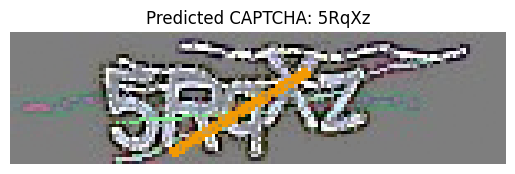

Predicted CAPTCHA: 5RqXz


In [17]:
model.eval()

def predict_captcha(image_path):
    image = Image.open(image_path)

    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    pixel_values = pixel_values.to(device)
    model.to(device)

    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    captcha_text = processor.decode(generated_ids[0], skip_special_tokens=True)
    return captcha_text

test_image_path = '/kaggle/input/c/opencode-24-geek-haven/test/test/1997.jpg'  

captcha_prediction = predict_captcha(test_image_path)

image = Image.open(test_image_path)
plt.imshow(image)
plt.title(f"Predicted CAPTCHA: {captcha_prediction}")
plt.axis('off')  
plt.show()

print(f"Predicted CAPTCHA: {captcha_prediction}")

In [18]:
import os
import pandas as pd

test_images_folder = '/kaggle/input/c/opencode-24-geek-haven/test/test'

image_names = []
labels = []

for filename in os.listdir(test_images_folder):
    if filename.endswith('.jpg') or filename.endswith('.png'):
        image_names.append(filename)
        labels.append('CAPTCHA')  

test = pd.DataFrame({
    'ID': image_names,
    'Label': labels
})

test.head() 

,ID,Label
0,7981.jpg,CAPTCHA
1,6234.jpg,CAPTCHA
2,1269.jpg,CAPTCHA
3,3863.jpg,CAPTCHA
4,6241.jpg,CAPTCHA


In [19]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

def predict_captcha(image_path):
    image = Image.open(image_path)

    pixel_values = processor(images=image, return_tensors="pt").pixel_values
    
    pixel_values = pixel_values.to(device)
    model.to(device)

    with torch.no_grad():
        generated_ids = model.generate(pixel_values)

    captcha_text = processor.decode(generated_ids[0], skip_special_tokens=True)
    return captcha_text

image_folder = '/kaggle/input/c/opencode-24-geek-haven/test/test'


tqdm.pandas()  
test['Label'] = test['ID'].progress_apply(
    lambda x: predict_captcha(os.path.join(image_folder, f"{x}"))
)

test.to_csv('predictions.csv', index=False)

print(test.head())

  0%|          | 0/10000 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1258: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(
100%|██████████| 10000/10000 [20:04<00:00,  8.30it/s]

         ID  Label
0  7981.jpg  wjPbW
1  6234.jpg  5iR8X
2  1269.jpg  KnMsB
3  3863.jpg  FD7vT
4  6241.jpg  Sf7Uf
